In [435]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model, tree, model_selection, ensemble, svm, metrics, naive_bayes
from sklearn import preprocessing

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/minghaooo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/minghaooo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/minghaooo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [436]:
df=pd.read_csv('fake_job_postings.csv')

In [437]:
#--------1. split the columns to country, state, and city

# to use country only?
df['country']=df.location.str.split(',',expand=True)[:][0]

df['state']=df.location.str.split(',',expand=True)[:][1]
df['city']=df.location.str.split(',',expand=True)[:][2]


#----------2. replacing different kinds of missing value to np.nan
df.state = df.state.str.strip()
df.state.fillna(value=np.nan, inplace=True)
df.state.replace('', np.nan, inplace=True)
df.state.replace(' ', np.nan, inplace=True)


#----------3. clear the whitespaces and signs at the start/end

df.city = df.city.str.strip(' /:\\')

#---------4. replacing different kinds of missing value to np.nan
df.city.fillna(value=np.nan, inplace=True)
df.city.replace('', np.nan, inplace=True)
df.city.replace(' ', np.nan, inplace=True)
df['city']=df.city.str.lower()


#---------4. spilt salary range into min and max

df.salary_range.fillna(value=np.nan, inplace=True)
df.salary_range.replace('', np.nan, inplace=True)
df.salary_range.replace(' ', np.nan, inplace=True)



df['min_salary']=df.salary_range.str.split('-',expand=True)[:][0]
df['max_salary']=df.salary_range.str.split('-',expand=True)[:][1]

df.max_salary.fillna(value=np.nan, inplace=True)


#----------5. for entry of salary_range as date, max and min salary are grouped as null value
df.loc[df['max_salary'].isin(['Apr', 'Dec', 'Jun', 'Nov', 'Oct', 'Sep']),['max_salary', 'min_salary']]=np.nan
df.loc[df['min_salary'].isin(['Dec', 'Jun', 'Oct']),['max_salary', 'min_salary']]=np.nan

#convert them into numerical value
df[['min_salary','max_salary']] = df[['min_salary','max_salary']].astype(float)

#for regression model, need to impute NaN values to median/mean
# df['max_salary'].fillna(value=df['max_salary'].mean(), inplace=True)
# df['min_salary'].fillna(value=df['min_salary'].mean(), inplace=True)

df.drop(['location', 'salary_range'], axis = 1, inplace = True)

df.columns

Index(['job_id', 'title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'telecommuting', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'country',
       'state', 'city', 'min_salary', 'max_salary'],
      dtype='object')

In [469]:
# this function for preprocessing text is used linked from the next function

'''def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'(?u)\b\w\w+\b')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords
'''

"def preprocess_text(text):\n    # Tokenise words while ignoring punctuation\n    tokeniser = RegexpTokenizer(r'(?u)\x08\\w\\w+\x08')\n    tokens = tokeniser.tokenize(text)\n    \n    # Lowercase and lemmatise \n    lemmatiser = WordNetLemmatizer()\n    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]\n    \n    # Remove stopwords\n    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]\n    return keywords\n"

In [470]:
'''df['text'] = df.apply(lambda row: (str(row['title']) + ' ' + 
                                   str(row['company_profile']) + ' ' + 
                                   str(row['description']) + ' ' + 
                                   str(row['requirements']) + ' ' + 
                                   str(row['benefits'])), axis = 1)

# Fill empty columns with "Unspecified"
df['text'] = df['text'].fillna("Unspecified")
    
# Create an instance of TfidfVectorizer
vectoriser = TfidfVectorizer(analyzer=preprocess_text, ngram_range = (1,2),   #TRY ADJUSTING ngram_range and min_df, max_df
                                min_df= 0.01, max_df= 0.6)

# Fit to the data and transform to feature matrix
text_column = vectoriser.fit_transform(df['text']).todense()

# Convert sparse matrix to dataframe
text_column = pd.DataFrame(text_column)

# Save mapping on which index refers to which words
col_map = {v:k for k, v in vectoriser.vocabulary_.items()}

# Rename each column using the mapping
for col in text_column.columns:
    text_column.rename(columns={col: col_map[col]}, inplace=True)
    '''

'df[\'text\'] = df.apply(lambda row: (str(row[\'title\']) + \' \' + \n                                   str(row[\'company_profile\']) + \' \' + \n                                   str(row[\'description\']) + \' \' + \n                                   str(row[\'requirements\']) + \' \' + \n                                   str(row[\'benefits\'])), axis = 1)\n\n# Fill empty columns with "Unspecified"\ndf[\'text\'] = df[\'text\'].fillna("Unspecified")\n    \n# Create an instance of TfidfVectorizer\nvectoriser = TfidfVectorizer(analyzer=preprocess_text, ngram_range = (1,2),   #TRY ADJUSTING ngram_range and min_df, max_df\n                                min_df= 0.01, max_df= 0.6)\n\n# Fit to the data and transform to feature matrix\ntext_column = vectoriser.fit_transform(df[\'text\']).todense()\n\n# Convert sparse matrix to dataframe\ntext_column = pd.DataFrame(text_column)\n\n# Save mapping on which index refers to which words\ncol_map = {v:k for k, v in vectoriser.vocabulary_.items(

In [439]:
text_column.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Columns: 2336 entries, 00 to zone
dtypes: float64(2336)
memory usage: 318.7 MB


In [440]:
columns_to_remove = ['title','company_profile', 'description', 'requirements', 'benefits']

for i in columns_to_remove:
  df[i] = df[i].fillna("unspecified")

df['title'] = df['title'].fillna("Unspecified")
df['requirements'] = df['requirements'].fillna("Unspecified")
df['benefits'] = df['benefits'].fillna("Unspecified")
df['company_profile'] = df['company_profile'].fillna("Unspecified")
df['description'] = df['description'].fillna("Unspecified")

df['has_title'] = df['title'].apply(lambda x: 0 if x == "unspecified" else 1)
df['has_requirements'] = df['company_profile'].apply(lambda x: 0 if x == "unspecified" else 1)
df['has_comp_profile'] = df['description'].apply(lambda x: 0 if x == "unspecified" else 1)
df['has_description'] = df['requirements'].apply(lambda x: 0 if x == "unspecified" else 1)
df['has_benefits'] = df['benefits'].apply(lambda x: 0 if x == "unspecified" else 1)

In [441]:
#df[['department', 'employment_type', 'required_experience', 'required_education',
#    'industry','function', 'country', 'state', 'city']]
def ohEncoder(col):
    onehot=preprocessing.OneHotEncoder()
    feature_array = onehot.fit_transform(col).toarray()
    feature_labels = np.array(onehot.categories_).ravel()
    feature_labels = np.array(feature_labels).ravel()
    
    new_df=pd.DataFrame(feature_array, columns=feature_labels)
    return new_df


cats=ohEncoder(df[['department']])

cats = pd.concat([cats, ohEncoder(df[['employment_type']])], axis =1, ignore_index=False)
cats = pd.concat([cats, ohEncoder(df[['required_experience']])], axis =1, ignore_index=False)
cats = pd.concat([cats, ohEncoder(df[['required_education']])], axis =1, ignore_index=False)
#cats = pd.concat([cats, ohEncoder(df[['industry']])], axis =1, ignore_index=False)
cats = pd.concat([cats, ohEncoder(df[['function']])], axis =1, ignore_index=False)
cats = pd.concat([cats, ohEncoder(df[['country']])], axis =1, ignore_index=False)
cats = pd.concat([cats, ohEncoder(df[['state']])], axis =1, ignore_index=False)
cats = pd.concat([cats, ohEncoder(df[['city']])], axis =1, ignore_index=False)

In [446]:
df.columns

Index(['job_id', 'title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'telecommuting', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'country',
       'state', 'city', 'min_salary', 'max_salary', 'has_title',
       'has_requirements', 'has_comp_profile', 'has_description',
       'has_benefits'],
      dtype='object')

In [451]:
others=df[['telecommuting', 'has_company_logo','has_questions', 'has_title','has_requirements', 'has_comp_profile', 'has_description','has_benefits']]

In [452]:
others

,telecommuting,has_company_logo,has_questions,has_title,has_requirements,has_comp_profile,has_description,has_benefits
0,0,1,0,1,1,1,1,0
1,0,1,0,1,1,1,1,1
2,0,1,0,1,1,1,1,0
3,0,1,0,1,1,1,1,1
4,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
17875,0,1,1,1,1,1,1,1
17876,0,1,1,1,1,1,1,1
17877,0,0,0,1,1,1,1,0
17878,0,0,1,1,0,1,1,1


In [453]:
cats.shape

(17880, 3850)

In [454]:
#scalar for text_column
scaled_features = preprocessing.StandardScaler().fit_transform(text_column.values)
scaled_text = pd.DataFrame(scaled_features, index=text_column.index, columns=text_column.columns)

In [456]:
cats.shape, others.shape

((17880, 3850), (17880, 8))

In [457]:
final_df=pd.concat([cats, others], axis =1, ignore_index=False)

In [458]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Columns: 3858 entries,   to has_benefits
dtypes: float64(3850), int64(8)
memory usage: 526.3 MB


In [459]:
y_trial = df[['fraudulent']]

In [460]:
final_df

,,\tCorporate Shared Services,Lower Level Management,Marketing,Moni Technologies,R&D,(Consultant),.NET,.net Development,0,...,마포구 동교동,NaN,telecommuting,has_company_logo,has_questions,has_title,has_requirements,has_comp_profile,has_description,has_benefits
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,0,1,1,1,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,0,1,1,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,0,1,1,1,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,0,1,1,1,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,1,1,1,1,1,1
17876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,1,1,1,1,1,1
17877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,1,1,1,0
17878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,1,1,0,1,1,1


In [461]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(final_df, y_trial, test_size=0.2, random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((14304, 3858), (14304, 1), (3576, 3858), (3576, 1))

In [462]:
y_trial

,fraudulent
0,0
1,0
2,0
3,0
4,0
...,...
17875,0
17876,0
17877,0
17878,0


In [343]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation,Embedding,GlobalAveragePooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


In [463]:
def create_model():
    model = Sequential()

    model.add(Dense(64, input_shape=(3858,), activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

In [464]:
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [20,30,40,50]
epochs = [10,20,30,40]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring = 'precision')
grid_result = grid.fit(X_train, y_train)

/Users/minghaooo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.
2022-06-17 23:53:53.538967: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 23:53:53.539726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 23:53:53.540314: I tensorflow/core/pla

In [465]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.835400 using {'epochs': 20, 'batch_size': 50}
0.787811 (0.047812) with: {'epochs': 30, 'batch_size': 20}
0.791044 (0.061926) with: {'epochs': 30, 'batch_size': 30}
0.744219 (0.054178) with: {'epochs': 10, 'batch_size': 30}
0.695228 (0.033903) with: {'epochs': 20, 'batch_size': 20}
0.762594 (0.021498) with: {'epochs': 20, 'batch_size': 40}
0.638236 (0.032651) with: {'epochs': 10, 'batch_size': 20}
0.835400 (0.037019) with: {'epochs': 20, 'batch_size': 50}
0.801952 (0.032576) with: {'epochs': 40, 'batch_size': 50}
0.774265 (0.018053) with: {'epochs': 20, 'batch_size': 30}
0.767701 (0.044323) with: {'epochs': 40, 'batch_size': 20}


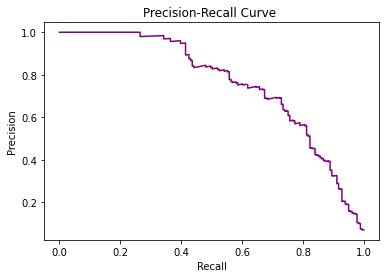

In [466]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

best=grid_result.best_estimator_

y_score = best.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve ')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

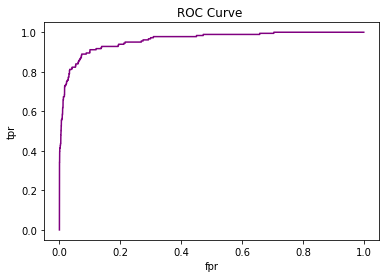

0.9591322956248628

In [467]:
#calculate precision and recall
fpr, tpr, thresholds = roc_curve(y_true_classes, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='purple')

#add axis labels to plot
ax.set_title('ROC Curve ')
ax.set_ylabel('tpr')
ax.set_xlabel('fpr')

#display plot
plt.show()
auc

In [468]:
best=grid_result.best_estimator_

y_pred_classes= best.predict(X_test) 
y_true_classes= y_test['fraudulent']

print(tf.math.confusion_matrix(labels=y_true_classes, predictions=y_pred_classes))

tf.Tensor(
[[3373   22]
 [  81  100]], shape=(2, 2), dtype=int32)


In [291]:
best